In [ ]:
# Samuel Petralia
# Github: stp283
# RDS 2022, Team Tablet

# This python script was written to help optimize the parameters of the 2R linkage for the tablet robot, RDS 2022.
# It uses the modern robotics library to run inverse kinematics and other jacobian calculations on the 2R arm kinematics
# to create color plots across the workspace of the tablet for parameters such as torques, condition number, and more.

In [35]:
# Libraries and config
import modern_robotics as mr
import numpy as np
np.set_printoptions(2)

import matplotlib
from IPython.display import Image

In [37]:
from math import atan, acos, sqrt, sin, cos
from numpy import pi

# atan2: num, num -> num
# returns the angle in radians of a point in the xy plane, range [-pi, pi]
def atan2(x, y):
    x_a = abs(x)
    y_a = abs(y)

    if y == 0:
        if x >= 0: return 0
        else: return pi
    elif x == 0:
        if y > 0: return pi/2
        else: return 3*pi/2
    # Quadrant 1
    if x > 0 and y > 0:
        return atan(y_a/x_a)
    # Quadrant 2
    elif x < 0 and y > 0:
        return pi - atan(y_a/x_a)
    # Quadrant 3
    elif x < 0 and y < 0:
        return -atan(y_a/x_a)
    # Quadrant 4
    else:
        return -pi + atan(y_a/x_a)


# Test cases for atan2()
assert atan2(5, 5) == pi/4
assert atan2(-5, 5) == 3*pi/4
assert atan2(-5, -5) == -pi/4
assert atan2(5, -5) == -3*pi/4
assert atan2(0, 10) == pi/2
assert atan2(10, 0) == 0
assert atan2(-10, 0) == pi
assert atan2(0, 0) == 0

# IK_2R: num, num, num, num -> [num, num]
# takes x,y coordinates of point in plane, lengths of links to solve inverse kinematics analytically
# for a 2R arm in a plane.  returns the angles from the base in the base frame.
def IK_2R(x, y, L1, L2):

    gamma = atan2(x, y)
    
    alpha = acos((x**2 + y**2 + L1**2 - L2**2) /
                 (2*L1*sqrt(x**2 + y**2)))

    beta = acos((L1**2 + L2**2 - x**2 - y**2)/
                (2*L1*L2))

    # print(f'gamma = {gamma}\nalpha = {alpha}\nbeta = {beta}')

    th1 = gamma - alpha
    th2 = pi - beta
    return [th1, th2]

# Test cases for IK_2R
assert IK_2R(0, 10, 5, 5) == [pi/2, 0]

# J_S: num, num, num, num -> array of num
# Takes joint angles and link lengths to solve for the space jacobian at that configuration 
# of the 2R robot
def J_S(th1, th2, L1, L2):
    return array([[-L1*sin(th1) - L2*sin(th1+th2), -L2*sin(th1+th2)],
                  [ L1*cos(th1) + L2*cos(th1+th2),  L2*cos(th1+th2)]])




In [38]:
## System Parameters
# Linkage parameters
A = 0.030  #[m] Horizontal coordinate to 2R base joint
B = 0.100  #[m] Vertical distance to 2R base joint
H = 0.150 #[m] Height of workspace (~7 inches)
W = 0.230  #[m] Width of workspace (~10 inches)
L1 = 0.180 #[m] Length of 2R link 1
L2 = 0.180 #[m] Length of 2R link 2

# Transmission parameters
stall_torque = 0.6  # N-m
cont_torque = 0.197 # N-m
gear_ratio = 5
pulley_ratio = 2.5
num_steps = 2048 * 4 # resolution of encoder
step_angle = 2*pi/num_steps/gear_ratio/pulley_ratio #rad

gearbox_backlash_deg = 0.1 #deg
gb_backlash = 0.1 * pi/180 #rad

rotor_inertia = 48 #g-cm^2
rotor_inertia_kgm2 = rotor_inertia / 1000 / 10000

speed_req = 0.15 #m/s

# Force paremeters
F = 6 #N
cont_out_torque = cont_torque * pulley_ratio * gear_ratio #N-m


In [39]:
from numpy import zeros, matmul, array
from numpy.linalg import inv
## Solve

# M matrix; SE3 matrix of end effector at home position
M = np.array([[1, 0, 0, L1 + L2],
              [0, 1, 0,       0],
              [0, 0, 1,       0],
              [0, 0, 0,       1]])
# Screw axes of joints in space frame
S1 = np.array([0, 0, 1, 0, 0, 0])
S2 = np.array([0, 0, 1, 0, -L1, 0])
Slist = np.column_stack((S1, S2))

# Screw axes of joints in body frame
B1 = np.array([0, 0, 1, -(L1+L2), 0, 0])
B2 = np.array([0, 0, 1, -L2, 0, 0])
Blist = np.column_stack((B1, B2))

# number of points to check, creates array of points inside tablet workspace
# at which each set of calculations is run
num_x = 100
num_y = 100
data = np.zeros((num_y, num_x))

# vectorize x, y locations in workspace for iteration
x_locs = np.linspace(-W/2 - A, W/2 - A, num_x).tolist()
y_locs = np.linspace(B, B+H, num_y).tolist()

# vectorized list of theta values, at 1 degree intervals
theta_vec = np.linspace(0, 2*pi, 361)

torque_bounds = [array([-cont_out_torque, -cont_out_torque]), 
                 array([-cont_out_torque, cont_out_torque]), 
                 array([cont_out_torque, -cont_out_torque]), 
                 array([cont_out_torque, cont_out_torque])]

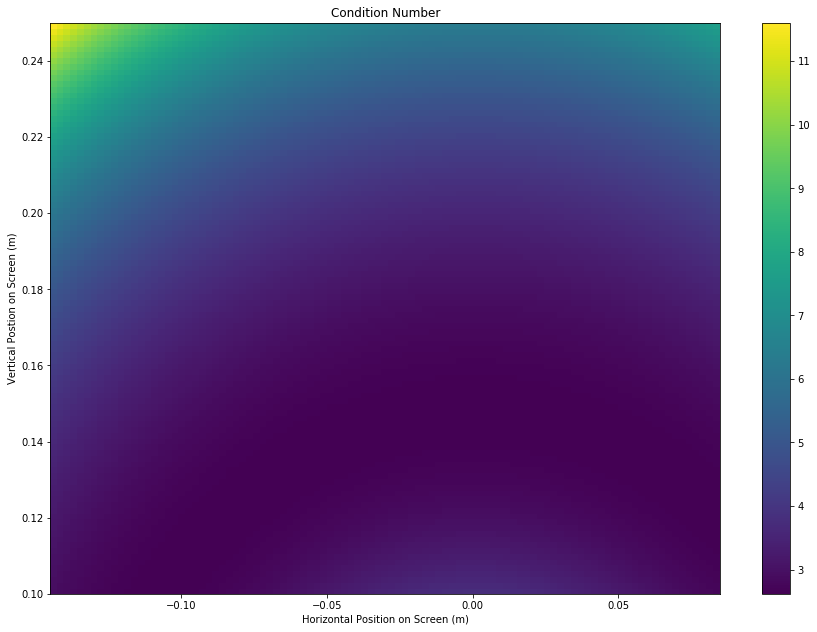

In [40]:
import matplotlib.pyplot as plt

#
# C O N D I T I O N   N U M B E R   C A L C U L A T I O N S
#

# Initialize data array
cond_data = zeros((num_y, num_x))
# Populate data array
for i in range(num_x):
    for j in range(num_y):
        # Analytic Inverse Kinematics
        thetalist = IK_2R(x_locs[i], y_locs[j], L1, L2)
        # Calculate 2X2 Jacobian Matrix
        Jb = mr.JacobianBody(Blist, thetalist)[3:5, :]
        # Calculate A matrix
        A_mat = np.matmul(Jb, Jb.T)
        # Find eigenvalues of matrix
        eig_vals = np.linalg.eigvals(A_mat).flatten()
        eig_vals = eig_vals[eig_vals > 0]
        # print(f'eig_vals = {eig_vals}')
        # Calculate condition number
        cond_data[j,i] = np.max(eig_vals) / np.min(eig_vals)


# Plot data array
def plot_condition():
    fig = plt.figure()
    plt.pcolormesh(x_locs, y_locs, cond_data)
    plt.colorbar()
    plt.gcf().set_size_inches(15, 10.5)
    plt.title('Condition Number')
    plt.xlabel('Horizontal Position on Screen (m)')
    plt.ylabel('Vertical Postion on Screen (m)')
    plt.show(fig)

plot_condition()

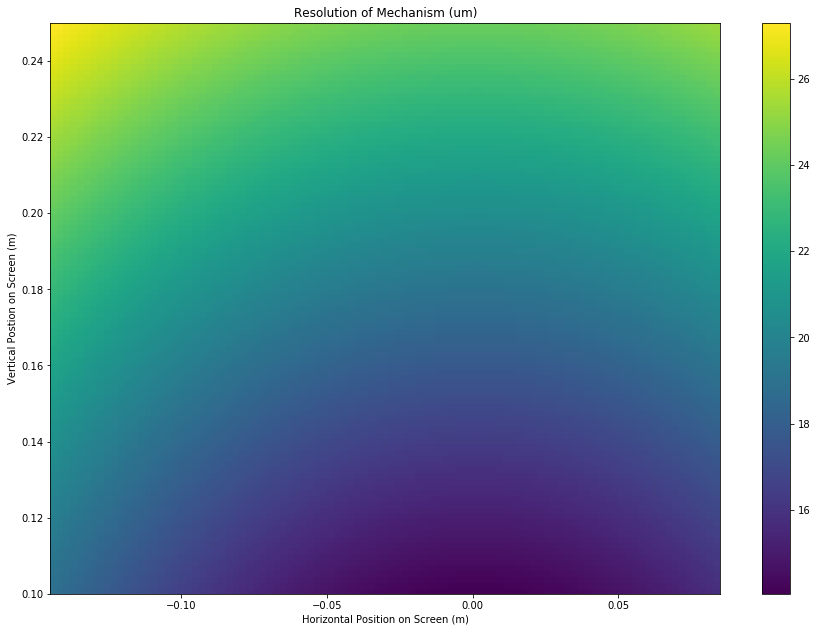

In [41]:
#
# R E S O L U T I O N   C A L C U L A T I O N S
#

res_data = zeros((num_y, num_x))

for i in range(num_x):
    for j in range(num_y):
        # Get x and y
        x = x_locs[i]
        y = y_locs[j]
        # Analytic Inverse Kinematics
        thetalist = IK_2R(x, y, L1, L2)
        # Calculate 2X2 Jacobian Matrix
        Js = J_S(thetalist[0], thetalist[1], L1, L2)
        # Find Twists from step in either joint
        V1 = np.matmul(Js, np.array([[step_angle], [step_angle]]))
        V2 = np.matmul(Js, np.array([[-step_angle], [-step_angle]]))
        # Calculate corresponding distances
        res1 = ( V1[0]**2 + V1[1]**2) ** 0.5
        res2 = ( V2[0]**2 + V2[1]**2) ** 0.5
        
        # Store resolution
        if res1 > res2: res_data[j,i] = res1 * 1000000
        else: res_data[j,i] = res2 * 1000000

# plot results
fig = plt.figure()
plt.pcolormesh(x_locs, y_locs, res_data)
plt.colorbar()
plt.gcf().set_size_inches(15, 10.5)
plt.title('Resolution of Mechanism (um)')
plt.xlabel('Horizontal Position on Screen (m)')
plt.ylabel('Vertical Postion on Screen (m)')
plt.show(fig)

In [42]:
#
# VELOCITY CALCULATIONS
#
rpm_data = zeros((num_y, num_x))
theta_vec = np.linspace(0, 2*pi, 181)

for i in range(num_x):
    for j in range(num_y):
        # Get x and y
        x = x_locs[i]
        y = y_locs[j]
        # Analytic Inverse Kinematics
        thetalist = IK_2R(x, y, L1, L2)
        # Calculate 2X2 Jacobian Matrix
        Js = J_S(thetalist[0], thetalist[1], L1, L2)
        # Calculate necessary speeds at each location
        max_angVel = 0
        #check speed in every direction
        for th in theta_vec:
            Vvec = speed_req * array([cos(th), sin(th)])
            # solve for angular velocity
            ang_vel = np.max(np.abs(matmul(inv(Js), Vvec)))
            # only keep velocity if it is greater
            if ang_vel > max_angVel: max_angVel = ang_vel
        # store max angular velocity as rpm
        rpm_data[j,i] = max_angVel * 60 / 2 / pi * pulley_ratio * gear_ratio


# plot results
fig = plt.figure()
plt.pcolormesh(x_locs, y_locs, rpm_data)
plt.colorbar()
plt.gcf().set_size_inches(15, 10.5)
plt.title('Necessary Motor Speed (RPM)')
plt.xlabel('Horizontal Position on Screen (m)')
plt.ylabel('Vertical Postion on Screen (m)')
plt.show(fig)

Maximum Backlash: 0.31178439826638926


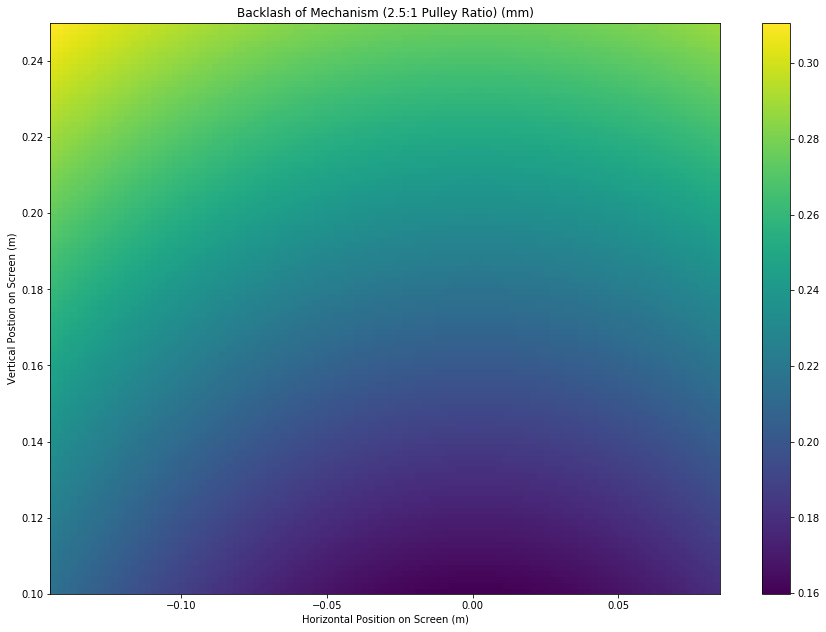

In [43]:
#
# B A C K L A S H   C A L C U L A T I O N S
#

backlash_angle = gb_backlash / pulley_ratio #rad
lash_data = zeros((num_y, num_x))

for i in range(num_x):
    for j in range(num_y):
        # Get x and y
        x = x_locs[i]
        y = y_locs[j]
        # Analytic Inverse Kinematics
        thetalist = IK_2R(x, y, L1, L2)
        # Calculate 2X2 Jacobian Matrix
        Js = J_S(thetalist[0], thetalist[1], L1, L2)

        # Calculate backlash at location
        V1 = np.matmul(Js, np.array([[backlash_angle], [backlash_angle]]))
        V2 = np.matmul(Js, np.array([[-backlash_angle], [-backlash_angle]]))

        # Calculate resolutions
        lash1 = ( V1[0]**2 + V1[1]**2) ** 0.5
        lash2 = ( V2[0]**2 + V2[1]**2) ** 0.5
        
        # take greater backlash and store the data
        if lash1 > lash2: lash_data[j,i] = lash1 * 1000
        else: lash_data[j,i] = lash2 * 1000

print(f'Maximum Backlash: {np.max(lash_data)}')

#plot results
fig = plt.figure()
plt.pcolormesh(x_locs, y_locs, lash_data)
plt.colorbar()
plt.gcf().set_size_inches(15, 10.5)
plt.title(f'Backlash of Mechanism ({pulley_ratio}:1 Pulley Ratio) (mm)')
plt.xlabel('Horizontal Position on Screen (m)')
plt.ylabel('Vertical Postion on Screen (m)')
plt.annotate(f'Max. Backlash:\n{np.max(lash_data):.3f}', (-0.155, 0.245) )
plt.show(fig)

8.520557214228765


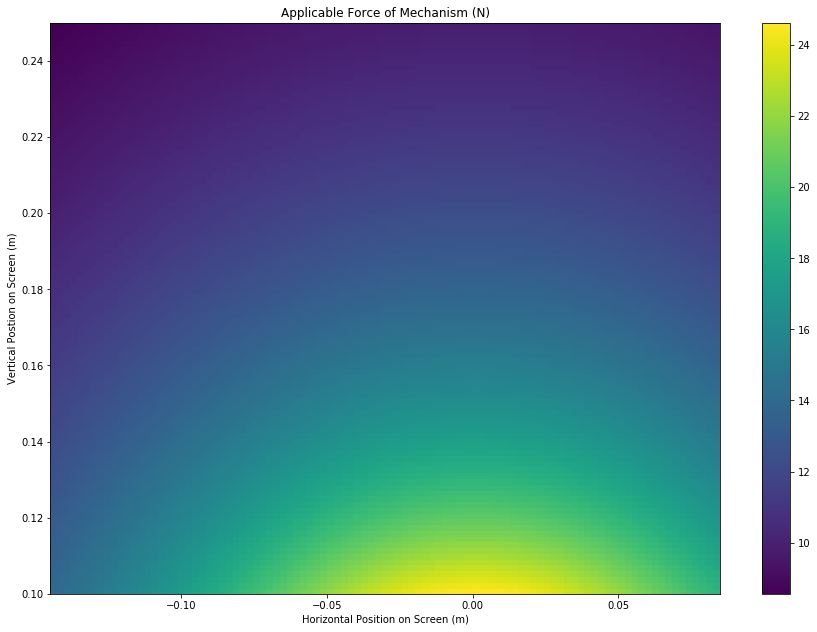

In [44]:
#
# FORCE CALCULATIONS
#

#empty array for data storage
force_data = zeros((num_y, num_x))

for i in range(num_x):
    for j in range(num_y):
        # Get x and y
        x = x_locs[i]
        y = y_locs[j]
        # Analytic Inverse Kinematics
        thetalist = IK_2R(x, y, L1, L2)
        # Calculate 2X2 Jacobian Matrix
        Jb = mr.JacobianBody(Blist, thetalist)[3:5, :]
        Js = J_S(thetalist[0], thetalist[1], L1, L2)

        # Calculate possible forces at location
        Fx_vec = []
        Fy_vec = []
        # run all cases of maximum torques, translate into force parallelgram
        for tor in torque_bounds:
            Fb = matmul(inv(Js.T), tor.T)
            Fx_vec.append(Fb[0])
            Fy_vec.append(Fb[1])

        # points on force parallelogram
        P0 = array([0, 0])
        P1 = array([Fx_vec[0], Fy_vec[0]])
        P2 = array([Fx_vec[1], Fy_vec[1]])
        P3 = array([Fx_vec[2], Fy_vec[2]])

        # Calculate points on force parallelogram nearest origin
        Min_F1 = np.linalg.norm(np.cross(P2 - P1, P1 - P0)) / np.linalg.norm(P2 - P1)
        Min_F2 = np.linalg.norm(np.cross(P3 - P2, P2 - P0))/np.linalg.norm(P3 - P2)
        # Take lesser of feasible forces
        if Min_F1 < Min_F2: force_data[j,i] = Min_F2
        else: force_data[j,i] = Min_F1


print(np.amin(force_data))

# plot results
fig = plt.figure()
plt.pcolormesh(x_locs, y_locs, force_data)
plt.colorbar()
plt.gcf().set_size_inches(15, 10.5)
plt.title('Applicable Force of Mechanism (N)')
plt.xlabel('Horizontal Position on Screen (m)')
plt.ylabel('Vertical Postion on Screen (m)')
plt.show(fig)

Max Torque Output Required: 1.7339996793046462


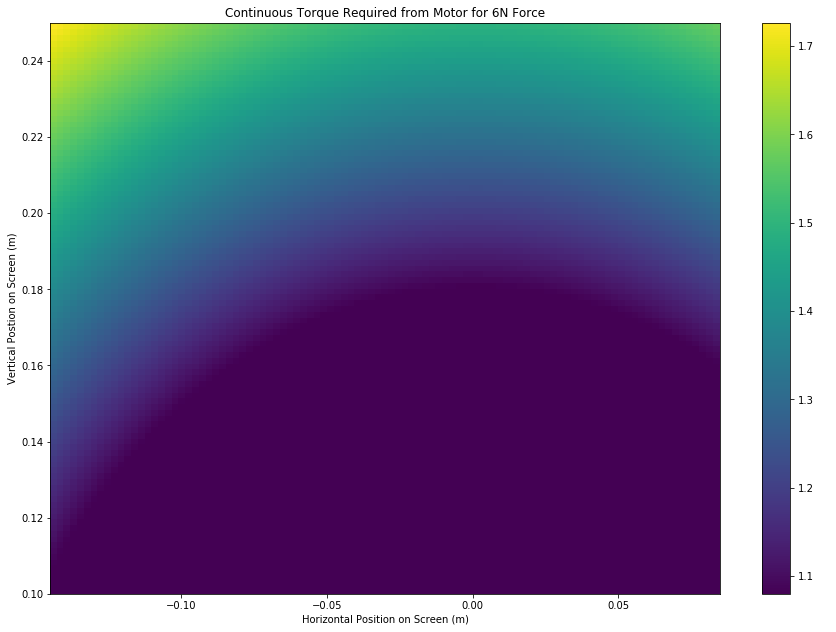

In [45]:
#
# TORQUE CALCULATIONS
#

#empty array to fill with data
torque_data = zeros((num_y, num_x))

for i in range(num_x):
    for j in range(num_y):
        # Get x and y
        x = x_locs[i]
        y = y_locs[j]
        # Analytic Inverse Kinematics
        thetalist = IK_2R(x, y, L1, L2)
        # Calculate 2X2 Jacobian Matrix
        Jb = mr.JacobianBody(Blist, thetalist)[3:5, :]
        # Js = J_S(thetalist[0], thetalist[1], L1, L2)

        # Calculate torques required in every direction
        max_tor = 0
        for th in theta_vec:
            # vectorize force value
            Fvec = F * array([cos(th), sin(th)])
            # solve for torques
            tor = np.max(np.abs(matmul(Jb.T, Fvec)))
            # only store max value
            if tor > max_tor: max_tor = tor
        # store worst case (largest required) torque
        torque_data[j,i] = max_tor

print(f'Max Torque Output Required: {np.max(torque_data)}')

# Plot results
fig = plt.figure()
plt.annotate(f'Max. Torque:\n{np.max(torque_data):.3f}', (0.1, 0.245) )
plt.pcolormesh(x_locs, y_locs, torque_data)
plt.colorbar()
plt.gcf().set_size_inches(15, 10.5)
plt.title(f'Continuous Torque Required from Motor for {F}N Force')
plt.xlabel('Horizontal Position on Screen (m)')
plt.ylabel('Vertical Postion on Screen (m)')
plt.show(fig)

Maximum Reflected Inertia: 32.020


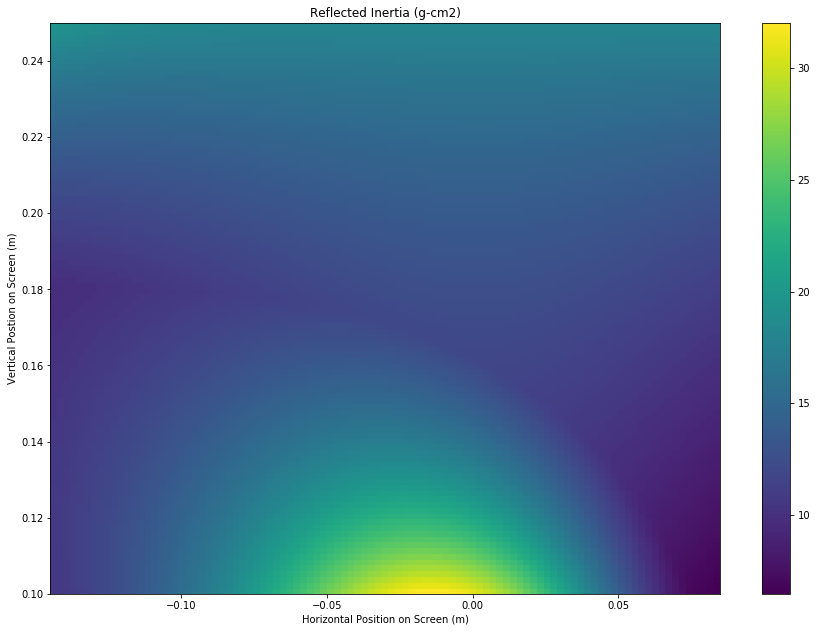

In [46]:
#
# INERTIA CALCULATIONS
#

# empty array for inertia data
iner_data = zeros((num_y, num_x))
# mass matrix of motor
MASS_M = np.array([[rotor_inertia_kgm2, 0],
                   [0, rotor_inertia_kgm2]])

for i in range(num_x):
    for j in range(num_y):
        # Get x and y
        x = x_locs[i]
        y = y_locs[j]
        # Analytic Inverse Kinematics
        thetalist = IK_2R(x, y, L1, L2)
        # Calculate 2X2 Jacobian Matrix
        Js = J_S(thetalist[0], thetalist[1], L1, L2)
        # Scale by overall reduction ratio
        Js = Js * pulley_ratio * gear_ratio
        # Calculate reflected inertia at each location
        rI = inv(Js.T) * MASS_M * inv(Js)
        rI_gcm2 = np.max(np.abs(rI * 1000 * 10000))
        iner_data[j,i] = rI_gcm2


print(f'Maximum Reflected Inertia: {np.max(iner_data):.3f}')
# plot results
fig = plt.figure()
plt.annotate(f'Max. Inertia:\n{np.max(iner_data):.3f}', (0.1, 0.245) )
plt.pcolormesh(x_locs, y_locs, iner_data)
plt.colorbar()
plt.gcf().set_size_inches(15, 10.5)
plt.title(f'Reflected Inertia (g-cm2)')
plt.xlabel('Horizontal Position on Screen (m)')
plt.ylabel('Vertical Postion on Screen (m)')
plt.show(fig)